<a href="https://colab.research.google.com/github/Kira8045/GAN-Implementation/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import tensorflow as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [46]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx1-ubyte.gz



--2020-02-08 12:35:34--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.73.142
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.73.142|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz.1’

train-images-idx3-u 100%[===================>]  25.20M  11.9MB/s    in 2.1s    

2020-02-08 12:35:37 (11.9 MB/s) - ‘train-images-idx3-ubyte.gz.1’ saved [26421880/26421880]

--2020-02-08 12:35:38--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.142
Connecting to fashion-mnist.s3-website.eu-central-1.

In [47]:
!mkdir MNIST_Fashion
! cp *.gz MNIST_Fashion/

mkdir: cannot create directory ‘MNIST_Fashion’: File exists


In [48]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz


In [0]:
learning_rate  =0.0002
batch_size = 128
epochs = 100000

image_dim = 784
gen_hidd_dim = 256
disc_hidd_dim = 256
z_noise_dim = 100

def xavier_init(shape):
  return tf.random.normal(shape = shape, stddev = 1/tf.sqrt(shape[0]/2.0))

In [0]:
weights = {
    "disc_H" : tf.Variable( xavier_init( [ image_dim, disc_hidd_dim ] ) ),
    "disc_final" : tf.Variable( xavier_init( [disc_hidd_dim ,  1] ) ),
    "gen_H" : tf.Variable(xavier_init([z_noise_dim, gen_hidd_dim])),
    "gen_final" : tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
}
bias = {
    "disc_H" : tf.Variable(xavier_init( [ disc_hidd_dim] )),
    "disc_final" : tf.Variable(xavier_init( [1] ) ),
    "gen_H" : tf.Variable(xavier_init( [gen_hidd_dim] )),
    "gen_final" : tf.Variable(xavier_init( [image_dim] ))
}

In [0]:
def Discriminator(x):
  hidden_layer = tf.nn.relu( tf.add( tf.matmul( x,weights["disc_H"]  ) , bias["disc_H"] ) )
  final_layer = tf.add(tf.matmul( hidden_layer, weights["disc_final"] ), bias["disc_final"] )
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer, disc_output

def Generator(x):
  hidden_layer = tf.nn.relu( tf.add( tf.matmul( x,weights["gen_H"]  ) , bias["gen_H"] ) )
  final_layer = tf.add(tf.matmul( hidden_layer, weights["gen_final"] ), bias["gen_final"] )
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output

z_input = tf.placeholder( tf.float32, shape = [ None, z_noise_dim ], name = "input_noise")
x_input = tf.placeholder( tf.float32, shape = [ None, image_dim ], name = "real_input")

with tf.name_scope("Generator") as scope:
  output_gen = Generator(z_input)

with tf.name_scope("Discriminator") as scope:
  real_output1_Disc, real_output_Disc = Discriminator(x_input)
  fake_output1_Disc, fake_output_Disc = Discriminator(output_gen)


In [0]:
with tf.name_scope("Discriminator_Loss") as scope:
  Discriminator_Loss = -tf.reduce_mean( tf.log( real_output_Disc + 0.0001 ) + tf.log( 1. - fake_output_Disc + 0.0001 ) )
with tf.name_scope("Generator_Loss") as scope:
  Generator_Loss = tf.reduce_mean( tf.log( fake_output_Disc + 0.0001 ) )

Disc_loss_total = tf.summary.scalar( "Disc_Loss_total", Discriminator_Loss )
Gen_loss_total = tf.summary.scalar( "Gen_Loss_total", Generator_Loss )


In [0]:
with tf.name_scope("Discriminator_Loss") as scope:
  Disc_real_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = real_output1_Disc, labels = tf.ones_like(real_output1_Disc) ) )
  Disc_fake_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = fake_output1_Disc, labels = tf.zeros_like(fake_output1_Disc) ) )
  Discriminator_Loss = Disc_real_loss + Disc_fake_loss
with tf.name_scope("Generator_Loss") as scope:
  Generator_Loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = fake_output1_Disc, labels= tf.ones_like(fake_output1_Disc) ) )

Disc_loss_real_summary = tf.summary.scalar( "Discriminator_real_loss",Disc_real_loss )
Disc_loss_fake_summary = tf.summary.scalar( "Discriminator_fake_loss",Disc_fake_loss )
Disc_loss_summary = tf.summary.scalar( "Discriminator_total_loss", Discriminator_Loss )
Disc_loss_total = tf.summary.merge( [ Disc_loss_real_summary, Disc_loss_fake_summary, Disc_loss_summary] )
Gen_loss_total = tf.summary.scalar( "Generator_Loss", Generator_Loss )

In [0]:
import tensorflow_probability as tfp
Generator_var = [ weights["gen_H"], weights["gen_final"], biases["gen_H"], biases["gen_final"] ]
Discriminator_var = [ weights["disc_H"], weights["disc_final"], biases["disc_H"], biases["disc_final"] ]

with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.AdamOptimizer( learning_rate= learning_rate ).minimize(Discriminator_Loss, var_list = Discriminator_var)

with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.AdamOptimizer( learning_rate= learning_rate).minimize( Generator_Loss, var_list = Generator_var ) 


In [0]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)
for epoch in range(epochs):
  x_batch, _ = mnist.train.next_batch(batch_size)
  z_noise = np.random.uniform( -1, 1, size = [batch_size, z_noise_dim] )
  _, Disc_loss_epoch = sess.run( [ Discriminator_optimize, Discriminator_Loss ], feed_dict = {x_input :x_batch, z_input : z_noise } )
  _,Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss] , feed_dict = {z_input: z_noise} )

  summary_Disc_Loss = sess.run(Disc_loss_total, feed_dict = { x_input : x_batch, z_input : z_noise })
  writer.add_summary(summary_Disc_Loss, epoch)

  summary_Gen_Loss = sess.run(Gen_loss_total, feed_dict = { z_input : z_noise })
  writer.add_summary(summary_Gen_Loss, epoch)
  if epoch%2000 ==0:
    print( "Steps", epoch, "/tGenerator_loss : ", Gen_loss_epoch, "\tDiscriminator_loss: ",Disc_loss_epoch )
  

Steps 0 /tGenerator_loss :  1.141367 	Discriminator_loss:  1.4550066
Steps 2000 /tGenerator_loss :  5.838198 	Discriminator_loss:  0.03354591
Steps 4000 /tGenerator_loss :  4.93762 	Discriminator_loss:  0.10547559
Steps 6000 /tGenerator_loss :  3.7142353 	Discriminator_loss:  0.25222838
Steps 8000 /tGenerator_loss :  3.398012 	Discriminator_loss:  0.26229975
Steps 10000 /tGenerator_loss :  3.3114724 	Discriminator_loss:  0.2733131
Steps 12000 /tGenerator_loss :  3.0144832 	Discriminator_loss:  0.48242354
Steps 14000 /tGenerator_loss :  2.9205518 	Discriminator_loss:  0.45985013
Steps 16000 /tGenerator_loss :  2.33579 	Discriminator_loss:  0.46037793
Steps 18000 /tGenerator_loss :  2.3788767 	Discriminator_loss:  0.53861827
Steps 20000 /tGenerator_loss :  2.663803 	Discriminator_loss:  0.6280863
Steps 22000 /tGenerator_loss :  2.2733645 	Discriminator_loss:  0.57863843
Steps 24000 /tGenerator_loss :  2.670679 	Discriminator_loss:  0.4049753
Steps 26000 /tGenerator_loss :  2.3089435 	Dis

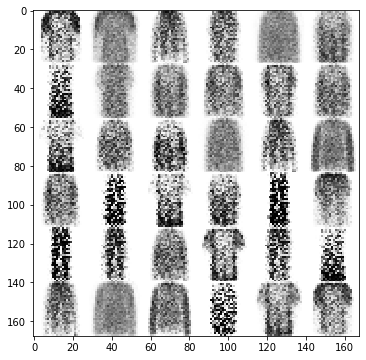

In [74]:
n = 6
canvas = np.empty ((28 *n,  28 *n ))
for i in range(n):
  z_noise = np.random.uniform(-1, 1, size = [batch_size, z_noise_dim])
  g = sess.run(output_gen, feed_dict = {z_input : z_noise})

  g = -1 * (g-1)
  for j in range(n):
    canvas[ i * 28: (i+1)*28, j*28 : (j+1)*28] = g[j].reshape([28,28])
  
plt.figure( figsize = (n, n) )
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()